<a href="https://colab.research.google.com/github/4deepprk/4deepprk.github.io/blob/master/DL_108_PyTorchCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

* Downloading dataset (CIFAR10)
* `Dataloader` in `torch.utils`
* Visualising images
* Single and multiple convolutional layers
* LeNet
* Training LeNet
* Training on GPU
* Simple visualisation
* Exercises

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np

## Data loading

In [2]:
import torchvision # library to do computer vision task using pytorch
import torchvision.transforms as transforms # apply certain function to dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
# labels for training dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
# from datasets created locally (trainset) we can load data from it in batch size
# of 4 images given randomly (to get rid off repetitiveness and escape local minima)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [5]:
dataiter = iter(trainloader) # to access the trainloader (datastructure) iter helps 
images, labels = dataiter.next() # get one instance of four images and their labels

print(images.shape) # one batch of data which contains 4 images (as batch size = 4)

print(images[0].shape)
print(labels[0].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
7


## Visualise data

In [6]:
img = images[0] 
print(type(img)) # type of tensor

<class 'torch.Tensor'>


In [7]:
npimg = img.numpy() # tensor type converted to numpy for plotting purpose
# size of numpy i.e., (z, x, y) or (0, 1, 2) or 
# (three channels, spatial dimension 1, spatial dimension 2)
print(npimg.shape)

(3, 32, 32)


In [8]:
# for higher dimension matrix transpose means any permutation of different axis
npimg = np.transpose(npimg, (1, 2, 0)) # (x, y, z)
print(npimg.shape)

(32, 32, 3)


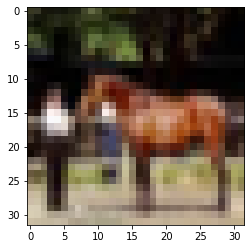

In [9]:
plt.figure(figsize = (4, 4)) # small size of the image
plt.imshow(npimg) # image plotting on matplotlib
plt.show()

In [0]:
# function to plot any image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

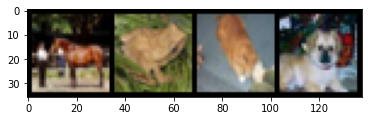

horse frog cat dog


In [11]:
# To plot entire batch of 4 images by using torchvision
imshow(torchvision.utils.make_grid(images)) # show all the images in the grid
# print(' '.join(classes[labels[1]] for 1 in range(4))) # for second image
print(' '.join(classes[labels[j]] for j in range(4)))


## Single Convolutional Layer

In [0]:
import torch.nn as nn # importing neural network from troch.nn

class FirstCNN(nn.Module): # inherting CNN from nn.Module
    def __init__(self): 
        super(FirstCNN, self).__init__() # calling init of the parent class
        # nn.Conv2d(#input channels, #kernels (output channels), width and height of the kernel (kernel size), padding, stride)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=(1,1), stride=(2,2)) # padding=(1,1), stride=(2,2))
        
    def forward(self, x): # # parameters (weights and biases) of the kernels
        x = self.conv1(x)
        return x

In [0]:
net = FirstCNN()

In [14]:
out = net(images)
out.shape

torch.Size([4, 16, 16, 16])

In [15]:
for param in net.parameters(): # parameters (weights and biases) of the kernels
    print(param.shape)

torch.Size([16, 3, 3, 3])
torch.Size([16])


In [16]:
# 0th out of 4 batch, 0th out of 16 channel, all columns, all rows
out1 = out[0, 0, :, :].detach().numpy() 
print(out1.shape)

(16, 16)


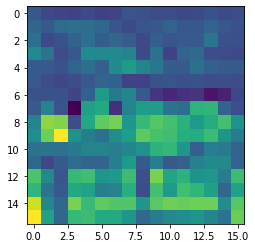

In [17]:
plt.imshow(out[0, 0, :, :].detach().numpy())
plt.show() # we can see some features of the image (in this random case it is a horse) preserved

## Deep Convolutional Network

In [0]:
class FirstCNN_v2(nn.Module):
    def __init__(self): 
        super(FirstCNN_v2, self).__init__()
        # sequential can stack multiple layers for creating a model
        self.model = nn.Sequential(
            nn.Conv2d(3, 8, 3),   # (N, 3, 32, 32) -> (N, 8, 30, 30)
            nn.Conv2d(8, 16, 3)   # (N, 8, 30, 30) -> (N, 16, 28, 28)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [19]:
net = FirstCNN_v2()
out = net(images)
out.shape

torch.Size([4, 16, 28, 28])

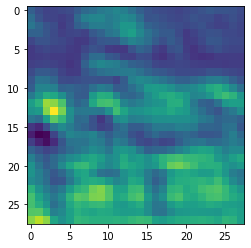

In [20]:
plt.imshow(out[0, 0, :, :].detach().numpy()) # we can see some patterns of horse here in this radom case

In [0]:
class FirstCNN_v3(nn.Module):
    def __init__(self): 
        super(FirstCNN_v3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),          # (N, 3, 32, 32) -> (N, 6, 28, 28)
            nn.AvgPool2d(2, stride=2),   # (N, 6, 28, 28) -> (N, 6, 14, 14)
            nn.Conv2d(6, 16, 5),         # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.AvgPool2d(2, stride=2)    # (N, 16, 10, 10) -> (N, 16, 5, 5)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [22]:
net = FirstCNN_v3()
out = net(images)
out.shape

torch.Size([4, 16, 5, 5])

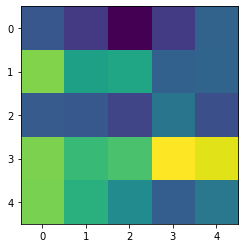

In [23]:
plt.imshow(out[0, 0, :, :].detach().numpy())

## LeNet

In [0]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        print(x.shape)
        x = self.cnn_model(x)
        print(x.shape)
        # Reshaping
        # (batch index remains same, -1 indicates the collapsing of all other indices)
        # .view is used to reshape tensors
        x = x.view(x.size(0), -1) # eg., (N, 16*5*5)
        print(x.shape)
        # Inference part does not use softmax as it is monotonic (even using softmax here gives the same result as linear combination) 
        x = self.fc_model(x) # but we will include softmax while training through cross entropy loss
        print(x.shape)
        return x

In [25]:
net = LeNet()
out = net(images)

torch.Size([4, 3, 32, 32])
torch.Size([4, 16, 5, 5])
torch.Size([4, 400])
torch.Size([4, 10])


In [26]:
# Note: We did not use softmax to infer the result in forward pass
print(out) # prints the 10 output neuron values for 4 images (batch size = 4)

tensor([[-0.1313,  0.0365, -0.0957, -0.0394,  0.1438, -0.0119, -0.0527, -0.0511,
          0.0292, -0.0508],
        [-0.1070,  0.0534, -0.1062, -0.0340,  0.1529, -0.0182, -0.0675, -0.0657,
          0.0157, -0.0504],
        [-0.1166,  0.0517, -0.1026, -0.0353,  0.1534, -0.0197, -0.0657, -0.0656,
          0.0263, -0.0625],
        [-0.1091,  0.0398, -0.1161, -0.0231,  0.1482, -0.0101, -0.0662, -0.0550,
          0.0251, -0.0549]], grad_fn=<AddmmBackward>)


In [27]:
# returns the inference result of untrained LeNet
max_values, pred_class = torch.max(out.data, 1)
print(pred_class) # prints the index of the maximum value in columnwise manner

tensor([4, 4, 4, 4])


## Training LeNet

In [0]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [29]:
batch_size = 128 # higher batch size (efficient to run on GPU's if we choose power of 2)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
net = LeNet()

In [0]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

Epoch: 0/16, Test acc: 37.64, Train acc: 37.88
Epoch: 1/16, Test acc: 42.92, Train acc: 42.43
Epoch: 2/16, Test acc: 47.30, Train acc: 47.65
Epoch: 3/16, Test acc: 48.92, Train acc: 50.14
Epoch: 4/16, Test acc: 51.25, Train acc: 53.55
Epoch: 5/16, Test acc: 52.10, Train acc: 54.75
Epoch: 6/16, Test acc: 53.50, Train acc: 57.30
Epoch: 7/16, Test acc: 53.20, Train acc: 57.01
Epoch: 8/16, Test acc: 55.02, Train acc: 59.45
Epoch: 9/16, Test acc: 55.37, Train acc: 60.97
Epoch: 10/16, Test acc: 55.03, Train acc: 62.17
Epoch: 11/16, Test acc: 55.37, Train acc: 62.62
Epoch: 12/16, Test acc: 56.15, Train acc: 63.76
Epoch: 13/16, Test acc: 55.94, Train acc: 64.32
Epoch: 14/16, Test acc: 56.37, Train acc: 65.91
Epoch: 15/16, Test acc: 56.17, Train acc: 66.26


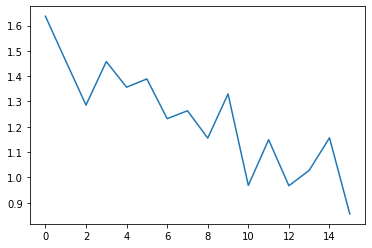

CPU times: user 8min 58s, sys: 7.17 s, total: 9min 5s
Wall time: 9min 6s


In [33]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 16

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

## Move to GPU

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
net = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

In [37]:
%%time
max_epochs = 16

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
    print('Epoch: %d/%d' % (epoch, max_epochs))

Epoch: 0/16
Epoch: 1/16
Epoch: 2/16
Epoch: 3/16
Epoch: 4/16
Epoch: 5/16
Epoch: 6/16
Epoch: 7/16
Epoch: 8/16
Epoch: 9/16
Epoch: 10/16
Epoch: 11/16
Epoch: 12/16
Epoch: 13/16
Epoch: 14/16
Epoch: 15/16
CPU times: user 2min 15s, sys: 1.04 s, total: 2min 16s
Wall time: 2min 16s


In [38]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(testloader), evaluation(trainloader)))

Test acc: 55.35, Train acc: 64.58


## Basic Visualisation

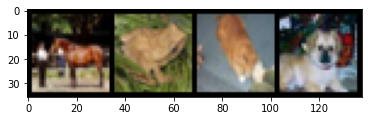

In [39]:
imshow(torchvision.utils.make_grid(images))

In [0]:
net = net.to('cpu')

In [41]:
out = net(images)
print(out.shape)

torch.Size([4, 10])


In [42]:
out = net.cnn_model[0](images) # to access a specific layer of the LeNet  
out.shape

torch.Size([4, 6, 28, 28])

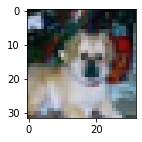

In [43]:
image_id = 3
plt.figure(figsize = (2,2))
imshow(images[image_id,])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


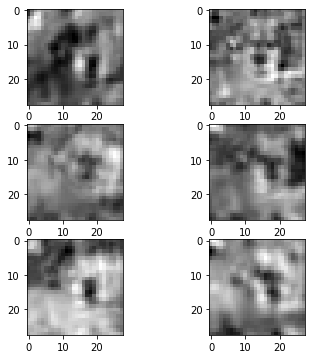

In [44]:
plt.figure(figsize = (6,6))
plt.subplot(321) # 3 rows and 2 columns
for i in range(6):
    ax1 = plt.subplot(3, 2, i+1)
    # plotting the rows and columns of 6 channels of 4th image from a specific layer 
    # using binary color map
    plt.imshow(out[image_id, i, :, :].detach().numpy(), cmap="binary")
plt.show()

## Exercises

* Modify LeNet to work with ReLU instead of Tanh -> What is the impact on training time, final loss
* We have observed over-fitting -> Use weight_decay in torch.optim to add L2 regularisation
* Instead of CIFAR10, use the MNIST data available from `torchvision.datasets.MNIST`. Download and visualise MNIST data.
* But importantly MNIST images have only 1 channel instead of 3 channels in the case of CIFAR10. Modify LeNet to work with MNIST. Train and find optimised test accuracy.